# Building your Recurrent Neural Network - Step by Step

## Recurrent Neural Network

Recurrent Neural Networks are designed to handle sequential data by maintaining a hidden state that captures information from previous time steps. This allows them to process inputs one at a time while retaining context.

## Long Short Term Memory(LSTM)

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs

## Components of LSTMs 
So the LSTM cell contains the following components

- Forget Gate “f” ( a neural network with sigmoid)
- Candidate layer “C"(a NN with Tanh)
- Input Gate “I” ( a NN with sigmoid )
- Output Gate “O”( a NN with sigmoid)
- Hidden state “H” ( a vector )
- Memory state “C” ( a vector)

Inputs to the LSTM cell at any step are Xt (current input) , Ht-1 (previous hidden state ) and Ct-1 (previous memory state).

Outputs from the LSTM cell are Ht (current hidden state ) and Ct (current memory state)

## Working of gates in LSTMs¶
First, LSTM cell takes the previous memory state Ct-1 and does element wise multiplication with forget gate (f) to decide if present memory state Ct. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

Ct = Ct-1 * ft

Calculating the new memory state:

Ct = Ct + (It * C`t)

Now, we calculate the output:

Ht = tanh(Ct)

In [2]:
%pip install pandas

  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## LSTMs for predicting the price of stocks of IBM for the Year 2017

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD 

import math
from sklearn.metrics import mean_squared_error


plt.style.use('fivethirtyeight')

In [4]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

### Getting Data 

In [5]:
dataset = pd.read_csv('./data.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


### Splitting Training and Test Datasets

In [39]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
training_set.shape

(2769, 1)

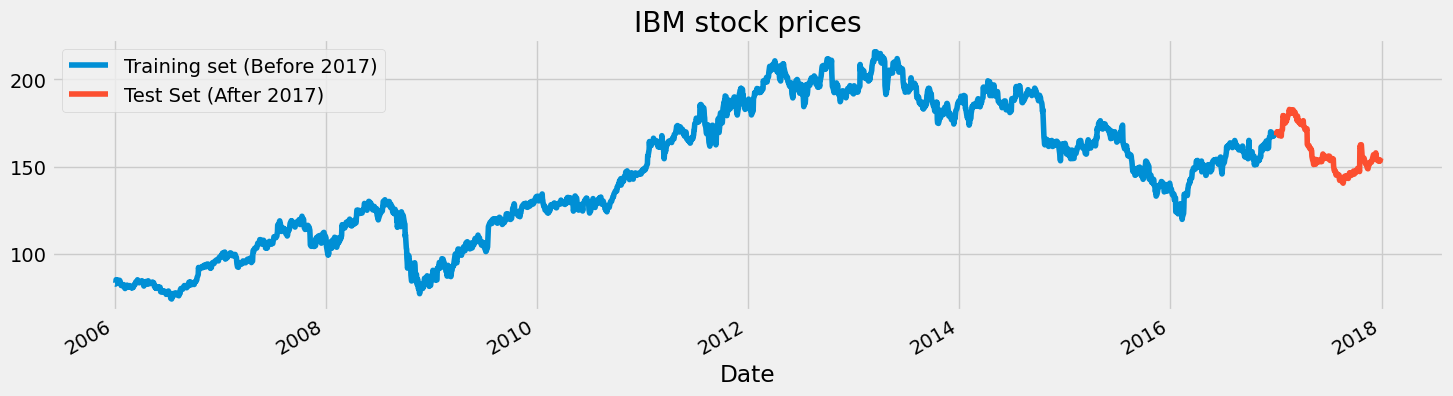

In [7]:
dataset['High'][:'2016'].plot(figsize=(16,4), legend=True)
dataset['High']['2017':].plot(figsize=(16,4), legend=True)

plt.legend(['Training set (Before 2017)', 'Test Set (After 2017)'])
plt.title('IBM stock prices')
plt.show()

### Scaling Datset

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

### NOTE - The LSTM network will use a sequence of 60 timesteps (previous time steps) to predict the next value (output). This is crucial for LSTMs, as they are designed to learn from sequences of data

In [9]:
X_train = [] # will store the input sequences
y_train = [] # will store the output values

for i in range(60, 2769): 
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping the Datasets

In [43]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(2709, 60, 1)

### LSTM Architecture

In [44]:
regressor = tf.keras.models.Sequential()

In [45]:
# First LSTM layer followed by Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer 
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer 
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer 
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units=1))

/opt/anaconda3/envs/image-classfn-env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compiling the RNN

In [46]:
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

### Training the RNN

In [47]:
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0444
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0110
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0089
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0073
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0063
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0055
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0053
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0049
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0045
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0048
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0042
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0035
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0037
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0031
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0033
Epoc

Now, we prepare our test dataset, ensuring that the first 60 entries in the test set can reference previous values. This requires access to the entire dataset, particularly focusing on the 'High' attribute

In [48]:
dataset_total = pd.concat((dataset['High'][:'2016'], dataset['High']['2017':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.fit_transform(inputs)

### Preparing X_test and predicting the prices 

In [49]:
X_test = []

for i in range(60, 311): 
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step 


### Visualizing the results for LSTM

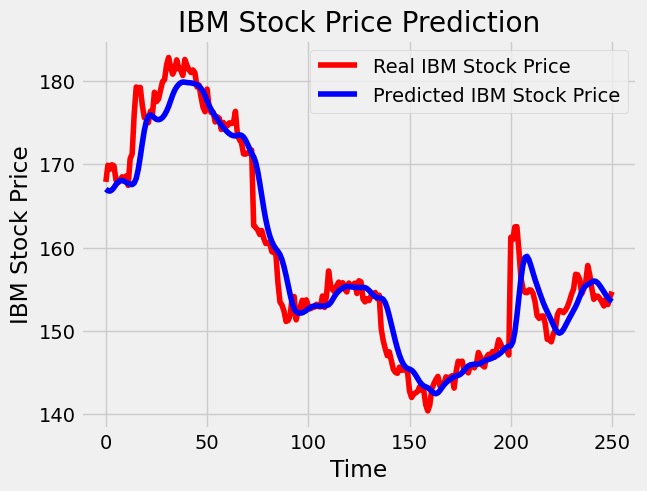

In [50]:
plot_predictions(test_set, predicted_stock_price)

In [51]:
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 3.0046704852099313.


Well, Although LSTM network has done a wonderful job. We still have Gated Recurrent Units(GRU) in our arsenal. Both have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units

Turns out the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. I can directly make use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize.
They are mostly similar to LSTMs except that they have two gates: reset and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM.

In [52]:
regressorGRU = tf.keras.models.Sequential()

In [53]:
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Output Layer 
regressorGRU.add(Dense(units=1))

/opt/anaconda3/envs/image-classfn-env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
# Compiling the GRNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error')

In [59]:
# Training the rregressorGRU Model 
regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150) 

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0024
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0021
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0024
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0022
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0022
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0021
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0022
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022
Epoc

In [60]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


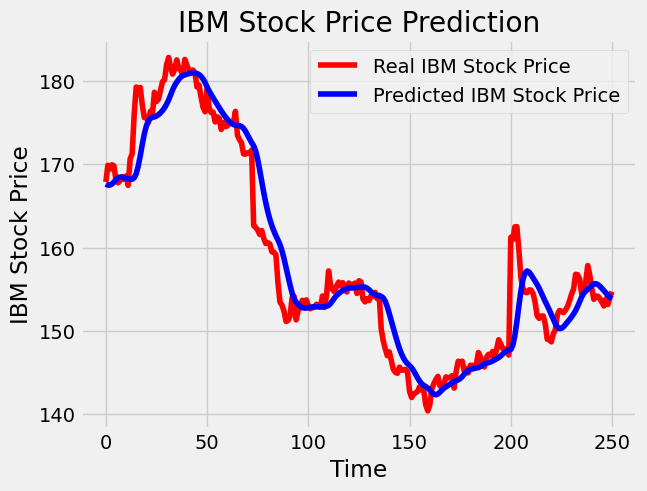

In [61]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [62]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.206373898237188.
